# Google Drive와 연동하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/'Colab Notebooks'/RL2023/TD
!ls
import sys; sys.path.append('..') # add project root to the python path
import numpy as np
import matplotlib.pyplot as plt
from gridworld import *
from tensorized_dp import TensorDP
import pickle

np.random.seed(0)

/content/drive/MyDrive/Colab Notebooks/RL2023/TD
episodes.pkl  gridworld.py  MC_TD_Practice.ipynb  __pycache__  tensorized_dp.py


## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [4]:
nx, ny = 5, 5
env = GridworldEnv([ny, nx])
gamma=1.0
lr=1e-3
dp_agent = TensorDP()
dp_agent.set_env(env)
v_pi = dp_agent.policy_evaluation()

Tensor DP agent initialized
Environment spec:  Num. state = 25 | Num. actions = 4 


/usr/local/lib/python3.9/dist-packages/gym/utils/seeding.py:41: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  deprecation(


In [3]:
def get_action(state):

        action = np.random.choice(range(4))

        return action

###  `run_episode()`

MC 기법은 하나의 에피소드가 진행되고 state,action,reward 정보를 모두 모아 반환합니다.


In [6]:
def run_episode(env, timeout=1000):
    env.reset()
    states = []
    actions = []
    rewards = []
    next_states=[]
    dones=[]

    i = 0
    timeouted = False
    while True:
        state = env.s
        action = get_action(state)
        next_state, reward, done, info = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)

        if done:
            break
        else:
            i += 1
            if i >= timeout:
                timeouted = True
                break

    if not timeouted:
        episode = (states, actions, rewards,next_states,dones)
    return episode

# Episodes 불러오기

에피소드 실행
- 에피소드 실시간 실행
- 에피소드 저장
- 에피소드 불러오기


In [18]:
episodes=[]
for _ in range(100000):
    episodes.append(run_episode(env))

with open('episodes.pkl', 'wb') as f:
    pickle.dump(episodes,f)

# with open('episodes.pkl','rb') as f:
#   episodes=pickle.load(f)

# MC
$$V(s) \leftarrow \frac{S(s)}{N(s)}$$
$$Q(s,a) \leftarrow \frac{S(s,a)}{N(s,a)}$$

$S(s)$ : 상태 s 에 대한 return들의 합 \\
$N(s)$ : 상태 s 를 방문한 횟수 \\
$S(s,a)$ : 상태 s에서 a 행동을 했을 때 return들의 값 \\
$N(s,a)$ : 상태 s에서 a 행동을 한 횟수

In [8]:
s_v=np.zeros(shape=nx*ny)
s_q = np.zeros(shape=(nx*ny,4))
n_v=np.zeros(shape=nx*ny)
n_q = np.zeros(shape=(nx*ny,4))
mc_error=[]


for episode in episodes:
    states, actions, rewards, _, _ = episode

    # reversing the inputs!
    # for efficient computation of returns
    states = reversed(states)
    actions = reversed(actions)
    rewards = reversed(rewards)

    iter = zip(states, actions, rewards)
    cum_r = 0
    for s, a, r in iter:
        cum_r *= gamma
        cum_r += r

        n_v[s] += 1
        n_q[s, a] += 1

        s_v[s] += cum_r
        s_q[s, a] += cum_r
    mc_error.append(np.linalg.norm(s_v/(n_v)-v_pi))
v_mc = s_v / (n_v )
q_mc = s_q / (n_q )

<ipython-input-8-f5011d756512>:28: RuntimeWarning: invalid value encountered in true_divide
  mc_error.append(np.linalg.norm(s_v/(n_v)-v_pi))


## 추산된 상태가치함수 $V(s)$ 및 $Q(s,a)$ 확인하기

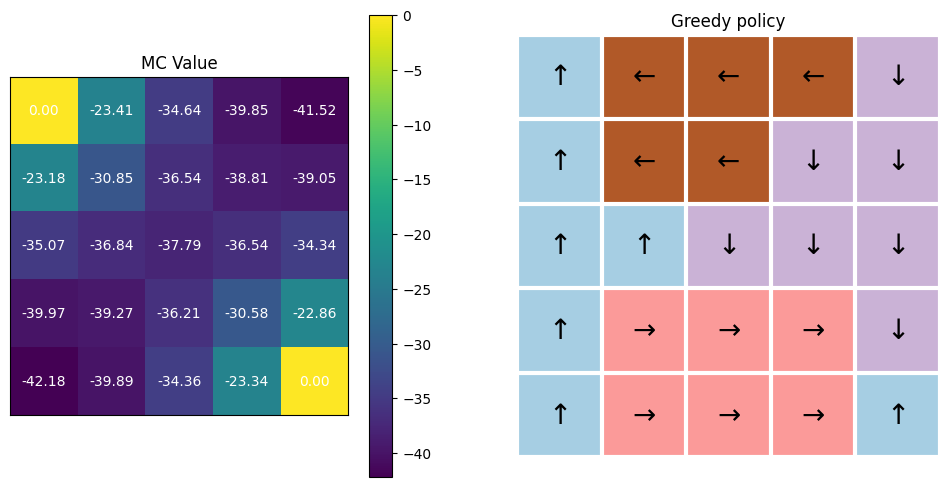

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_mc, nx, ny)
_ = ax[0].set_title("MC Value")
visualize_policy(ax[1], q_mc, nx, ny)
_ = ax[1].set_title("Greedy policy")

## Incremental MC 


$$V(s) \leftarrow V(s) + \alpha (G(s) - V(s))$$
$$Q(s,a) \leftarrow Q(s,a) + \alpha (G(s,a) - Q(s,a))$$

$\alpha$: learning rate \\
$G(s)$:상태 s에서의 return \\
$G(s,a)$: 상태 s, 행동 a에서의 return

In [10]:
v_incre=np.zeros(shape=nx*ny)
q_incre = np.zeros(shape=(nx*ny,4))
mc_incre_error=[]

for episode in episodes:
    states, actions, rewards,_,_ = episode

    # reversing the inputs!
    # for efficient computation of returns
    states = reversed(states)
    actions = reversed(actions)
    rewards = reversed(rewards)

    iter = zip(states, actions, rewards)
    cum_r = 0
    for s, a, r in iter:
        cum_r *= gamma
        cum_r += r

        v_incre[s] += lr * (cum_r - v_incre[s])
        q_incre[s, a] += lr * (cum_r - q_incre[s, a])
    mc_incre_error.append(np.linalg.norm(v_incre-v_pi))

## 추산된 상태가치함수 $V(s)$ 및 $Q(s,a)$ 확인하기

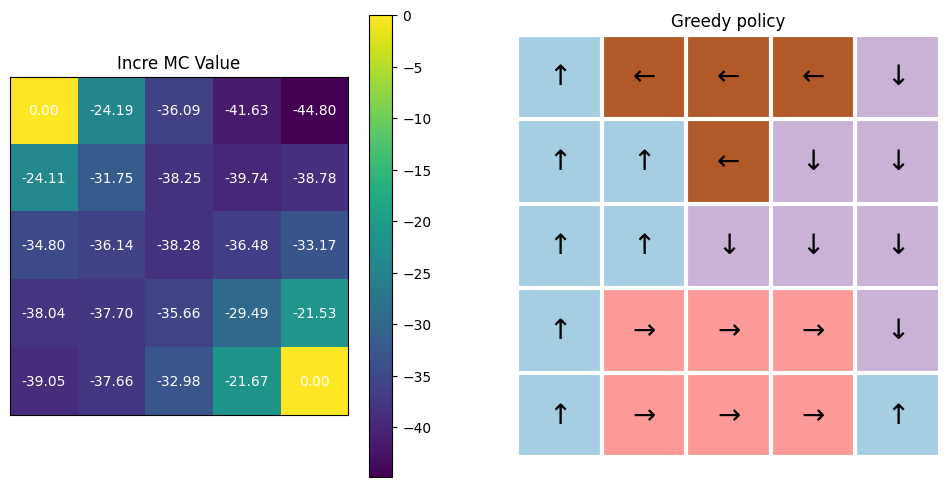

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0],v_incre, nx, ny)
_ = ax[0].set_title("Incre MC Value")
visualize_policy(ax[1],q_incre, nx, ny)
_ = ax[1].set_title("Greedy policy")

## 1-step TD; TD(0)

1-step TD &ndash; 혹은 TD(0) &ndash; 의 사례부터 살펴보도록 하죠. 1-step TD의 업데이트 공식은 다음과 같습니다.

$$V(s) \leftarrow V(s) + \alpha (G_t - V(s))$$ 
$$G_t = R_{t+1} + \gamma V(s_{t+1}) $$

수식에서도 확인하실수 있듯이, 1-step TD는 $(s_t, a_t, r_t, s_{t+1})$ 만으로도 업데이트를 수행할 수 있습니다.

그렇기 때문에 TD 방식은 MC 방식과 달리 Episode를 진행하는 도중에 Value를 추산할 수 있습니다.

In [19]:
td_error = []
v_td = np.zeros(shape=nx*ny)
q_td = np.zeros(shape=(nx*ny,4))

for episode in episodes:

  states,actions,rewards,next_states,dones=episode
  iter=zip(states,actions,rewards,next_states,dones)

  for state,action,reward,next_state,done in iter:

    # 1-step TD target
    # V 함수 추정
    td_target = reward + gamma * v_td[next_state] * (1 - done)
    v_td[state] += lr * (td_target - v_td[state])
    # Q 함수 추정
    td_target=reward+gamma*q_td[next_state,np.argmax(q_td[next_state])]* (1 - done)
    q_td[state,action]+=lr*(td_target-q_td[state,action])
    
  td_error.append(np.linalg.norm(v_td-v_pi))

## 추산된 상태가치함수 $V(s)$ 및 $Q(s,a)$ 확인하기

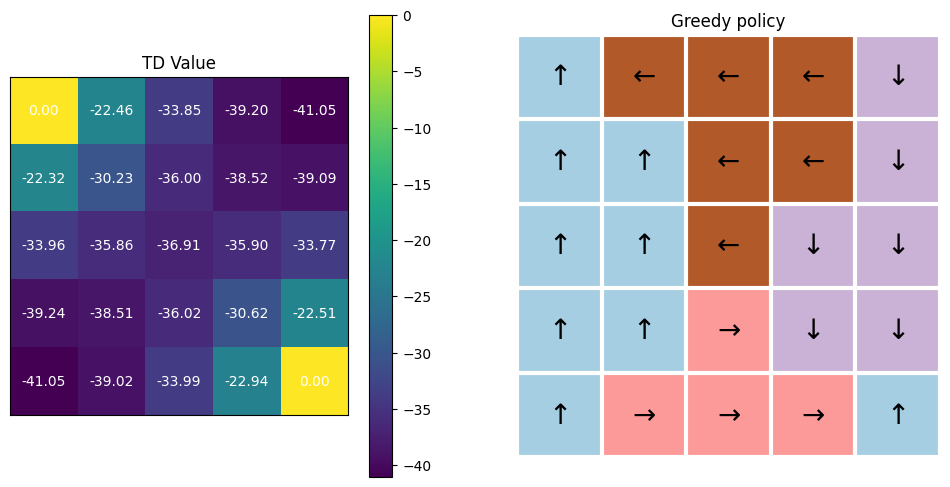

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0],v_td, nx, ny)
_ = ax[0].set_title("TD Value")
visualize_policy(ax[1], q_td, nx, ny)
_ = ax[1].set_title("Greedy policy")

# DP 방식과 비교하기

우리는 Model 에 대한 정보를 모르는 상태에서 Monte Carlo, TD 방식으로 가치를 추산합니다. 그런데 정말 우리가 추산한 가치가 제대로 된 가치일까요?

DP 로 구한 가치값과 비슷한지 비교해 봅시다.

#MC vs DP

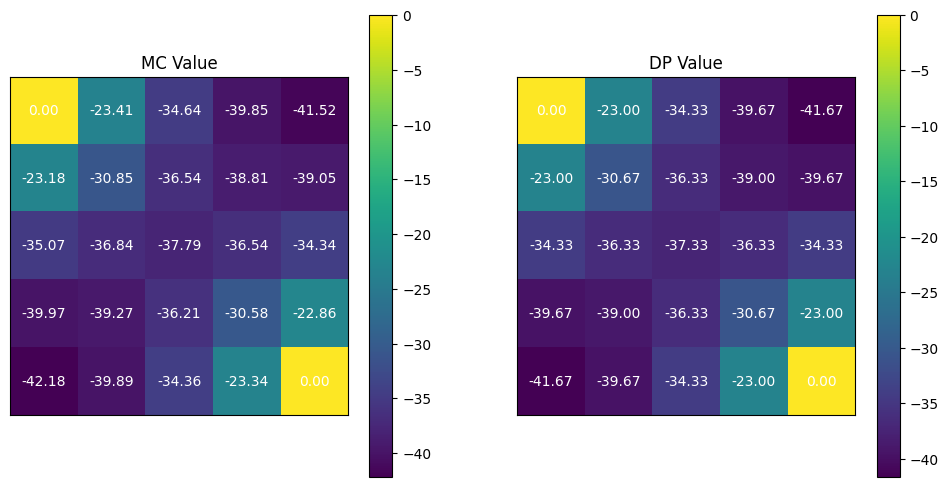

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_mc, nx, ny)
_ = ax[0].set_title("MC Value")
visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("DP Value")

# Incremental MC vs DP

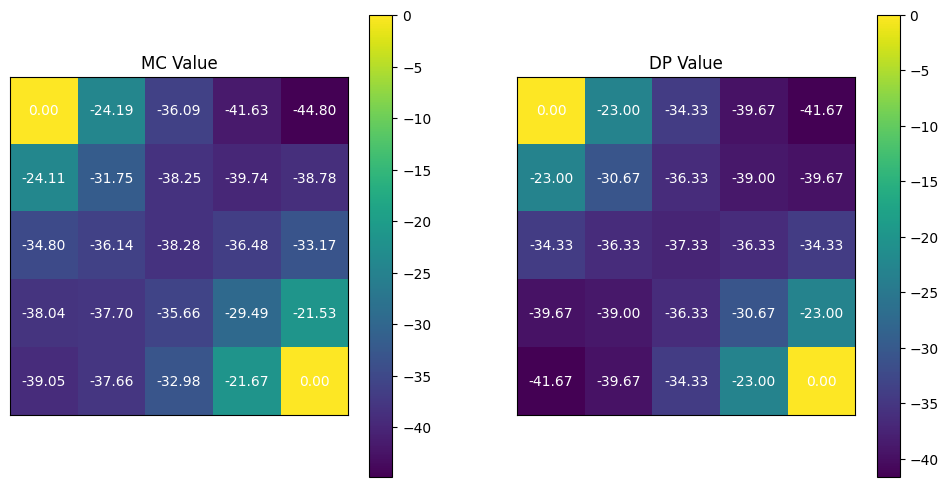

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_incre, nx, ny)
_ = ax[0].set_title("MC Value")
visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("DP Value")

# TD vs DP

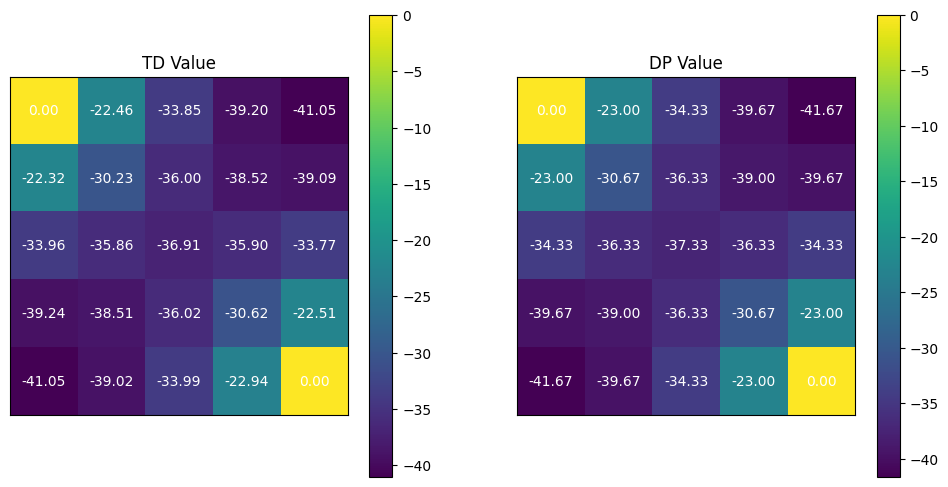

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_td, nx, ny)
_ = ax[0].set_title("TD Value")
visualize_value_function(ax[1], v_pi, nx, ny)
_ = ax[1].set_title("DP Value")

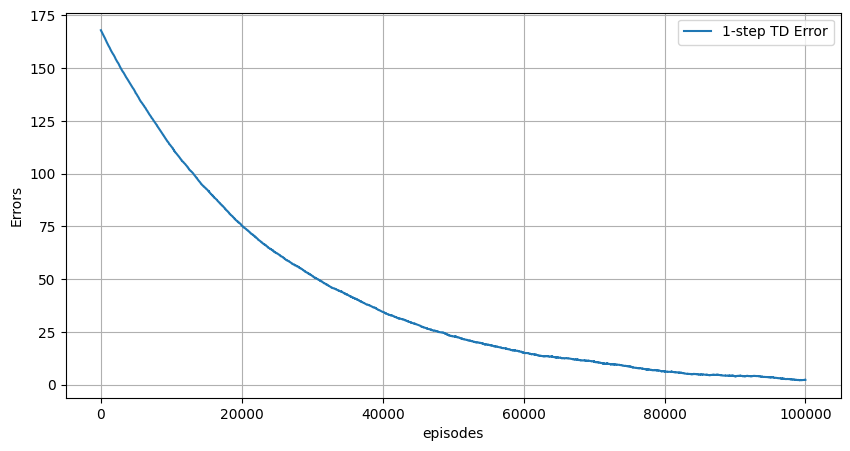

In [28]:
iters=np.arange(100000)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid()
# ax.plot(iters, mc_error, label='MC Error')
# ax.plot(iters, mc_incre_error, label='Incremental MC Error')
ax.plot(iters, td_error, label='1-step TD Error')
ax.legend()
_ = ax.set_xlabel('episodes')
_ = ax.set_ylabel('Errors')